In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf
from pandas_datareader import data as pdr
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Use yfinance to fetch data
yf.pdr_override()

# Fetching data for Apple Inc. (AAPL)
stock_data = pdr.get_data_yahoo('AAPL', start='2020-01-01', end='2021-01-01')

print(stock_data.head())
df = stock_data.copy()


name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.keras.layers.Dense(256, activation=tf.nn.relu)(self.X)
        self.logits = tf.keras.layers.Dense(self.action_size)(feed)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(self.sess.run(self.logits, feed_dict={self.X: state})[0])

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict={self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: X, self.Y: Y})
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f' % (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                      % (t, self.trend[t], invest, initial_money))
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost, starting_money))


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251137  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826851  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484337  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.650345  132079200


epoch: 10, total rewards: 349.845016.3, cost: 0.860285, total money: 2267.507542
epoch: 20, total rewards: 737.297504.3, cost: 0.379656, total money: 5259.725033
epoch: 30, total rewards: 748.867496.3, cost: 0.249719, total money: 6053.775021
epoch: 40, total rewards: 770.639999.3, cost: 0.198991, total money: 6110.335022
epoch: 50, total rewards: 614.069988.3, cost: 0.152927, total money: 6796.765011
epoch: 60, total rewards: 642.514996.3, cost: 0.128077, total money: 7229.315014
epoch: 70, total rewards: 472.194996.3, cost: 0.111372, total money: 7616.765011
epoch: 80, total rewards: 426.507496.3, cost: 0.097803, total money: 7829.240017
epoch: 90, total rewards: 396.897503.3, cost: 0.085853, total money: 8295.437519
epoch: 100, total rewards: 279.192516.3, cost: 0.079638, total money: 8428.722523
epoch: 110, total rewards: 228.275013.3, cost: 0.073441, total money: 8608.295017
epoch: 120, total rewards: 86.557522.3, cost: 0.068890, total money: 8682.317524
epoch: 130, total rewards:

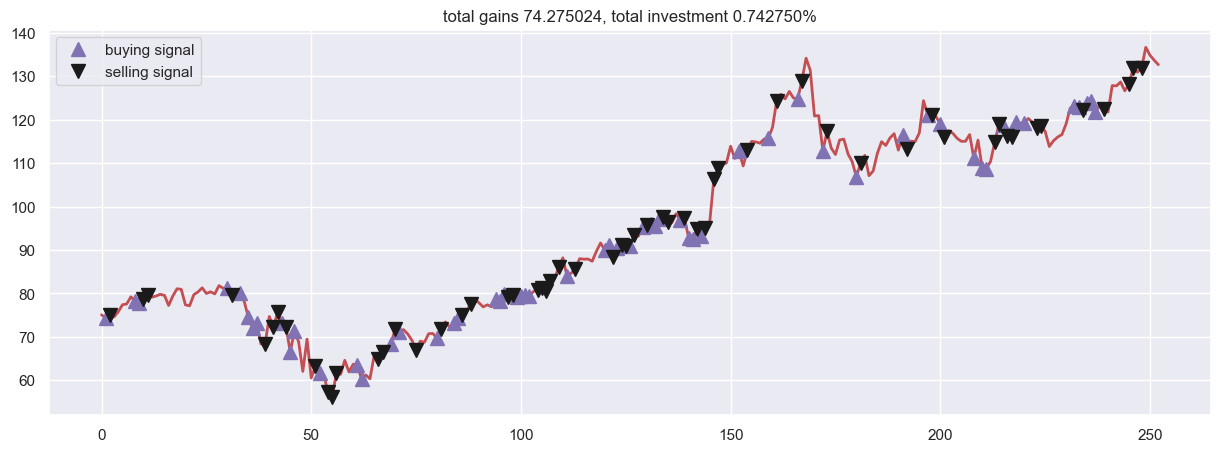

In [26]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32

agent = Agent(state_size=window_size, window_size=window_size, trend=close, skip=skip, batch_size=batch_size)
agent.train(iterations=200, checkpoint=10, initial_money=initial_money)
import matplotlib.pyplot as plt

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32

agent = Agent(state_size=window_size, window_size=window_size, trend=close, skip=skip, batch_size=batch_size)
agent.train(iterations=200, checkpoint=10, initial_money=initial_money)

states_buy, states_sell, total_gains, invest = agent.buy(initial_money)

fig = plt.figure(figsize=(15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='buying signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='selling signal', markevery=states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

